In [128]:
%matplotlib inline 
import matplotlib.pyplot as plt
from astropy.time import Time
import astropy.units as u
import numpy as np

Let's say we have these three observatories, CFHT (Hawaii), Siding Spring Observatory (Australia), and Kitt Peak (Arizona): 

In [148]:
from astroplan import Observer
observatories = [Observer.at_site("CFHT"), 
                 Observer.at_site("SSO"),
                 Observer.at_site("KPNO")]

Let's say our gravitational wave candidate has a broad posterior distribution on the sky, which we can approximate with three coordinates (widely separated):

In [149]:
from astroplan import FixedTarget
from astropy.coordinates import SkyCoord

coord_0 = SkyCoord(ra='20h40m10s', dec='-30d10m50s')
coord_1 = SkyCoord(ra='21h40m10s', dec='00d10m50s')
coord_2 = SkyCoord(ra='22h50m10s', dec='30d10m50s')

target_list = [FixedTarget(coord=coord_0, name='GW-180430_0'),
               FixedTarget(coord=coord_1, name='GW-180430_1'),
               FixedTarget(coord=coord_2, name='GW-180430_2')]

Make a list of constraints that we demand must be met for a the target to be "observable"

In [150]:
from astroplan import (AirmassConstraint, AtNightConstraint,
                       MoonSeparationConstraint)

constraints = [AirmassConstraint(max=2.5), 
               AtNightConstraint.twilight_civil(),
               MoonSeparationConstraint(min=5*u.deg)]

Make a grid of times, every hour, for 72 hours, starting at the time below; and compute the constraints for each target at each time for each observatory: 

In [151]:
times = Time('2018-04-30 00:00') + np.arange(0, 72, 1) * u.hour

constraint_matrix = np.ones((len(observatories), len(target_list), len(times))).astype(bool)

for i, observatory in enumerate(observatories):
    for constraint in constraints:
        constraint_matrix[i, :, :] &= constraint(observatory, target_list, times, grid_times_targets=True)

Plot the results: 

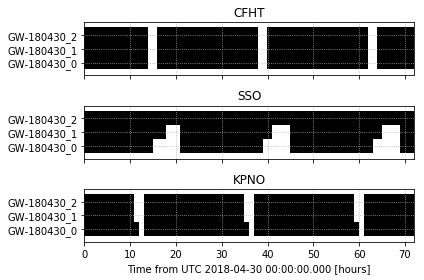

In [152]:
fig, ax = plt.subplots(len(observatories), sharex=True)

for i, observatory in enumerate(observatories):
    ax[i].imshow(constraint_matrix[i, ...], cmap=plt.cm.Greys_r, origin='lower', 
                 extent=[0, len(times), 0, len(observatories)])
    ax[i].set_aspect(3)
    ax[i].set_title(observatory.name)

for axis in fig.axes:
    axis.set_yticks(np.arange(len(target_list))+0.5)
    axis.set_yticklabels([target.name for target in target_list])
    axis.grid(ls=':')
ax[-1].set_xlabel('Time from UTC {0} [hours]'.format(times[0].utc.iso))
fig.tight_layout()
plt.show()

The above plot is black when the constraints are not met, and white when the constraints are met, for each observatory, at each time. 